# Code for Fig. 4, fig. S4, and Table 1 of
#### Yeager et al., 2021: An Outsized Role for the Labrador Sea in the Multidecadal Variability of the Atlantic Overturning Circulation, *Science Advances*.

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal,stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def open_POPdataset(x):
    ds = xr.open_dataset(x,decode_times=False)
    attrs=ds.time.attrs.copy()
    ds = ds.assign_coords(time=ds.time.values - 15)
    ds.time.attrs = attrs
    ds = xr.decode_cf(ds)
    return ds

In [3]:
datadir = '/glade/scratch/yeager/YeagerEA_ScienceAdvances_2021/'
f2_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.020001_050012.MOCsig.nc'
f3_hr = f'{datadir}/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.020001_050012.WMF.nc'
ds2_hr = open_POPdataset(f2_hr) 
ds3_hr = open_POPdataset(f3_hr) 

In [4]:
# Add combined regions to WMF datasets
ds3_hr1 = ds3_hr.isel(wmf_region=[1,2,3,5,6]).sum('wmf_region')
ds3_hr1 = ds3_hr1.assign_coords({'wmf_region':'ALL minus LAB (7)'})
ds3_hr2 = ds3_hr.isel(wmf_region=[1,2,3]).sum('wmf_region')
ds3_hr2 = ds3_hr2.assign_coords({'wmf_region':'IRM+SPG (8)'})
ds3_hr3 = ds3_hr.isel(wmf_region=[1,4]).sum('wmf_region')
ds3_hr3 = ds3_hr3.assign_coords({'wmf_region':'LAB+SPG-west (9)'})
ds3_hr4 = ds3_hr.isel(wmf_region=[2,3]).sum('wmf_region')
ds3_hr4 = ds3_hr4.assign_coords({'wmf_region':'IRM+SPG-east (10)'})
ds3_hr5 = ds3_hr.isel(wmf_region=[2,3,5,6]).sum('wmf_region')
ds3_hr5 = ds3_hr5.assign_coords({'wmf_region':'ALL minus LAB+SPG-west (11)'})
ds3_hr = xr.concat([ds3_hr,ds3_hr1,ds3_hr2,ds3_hr3,ds3_hr4,ds3_hr5],dim='wmf_region')

In [5]:
ds3_hr.wmf_region

<xarray.DataArray 'wmf_region' (wmf_region: 12)>
array(['All (>0)', 'SPG_west (1)', 'SPG_east (2)', 'Irminger Sea (3)',
       'Labrador Sea (4)', 'Norwegian Sea (5)', 'Arctic (6)',
       'ALL minus LAB (7)', 'IRM+SPG (8)', 'LAB+SPG-west (9)',
       'IRM+SPG-east (10)', 'ALL minus LAB+SPG-west (11)'], dtype=object)
Coordinates:
  * wmf_region  (wmf_region) object 'All (>0)' ... 'ALL minus LAB+SPG-west (11)'

## Compute Annual Anomalies and Std Dev (years 200-500)

In [6]:
ds2_hr_ann = ds2_hr.groupby('time.year').mean('time')
ds2_hr_ann=ds2_hr_ann.rename({'year':'time'}).sel(time=slice(200,501))
ds3_hr_ann = ds3_hr.groupby('time.year').mean('time')
ds3_hr_ann=ds3_hr_ann.rename({'year':'time'}).sel(time=slice(200,501))

In [7]:
ds2_hr_mean = ds2_hr_ann.mean('time')
ds2_hr_annanom = ds2_hr_ann - ds2_hr_mean
ds3_hr_mean = ds3_hr_ann.mean('time')
ds3_hr_annanom = ds3_hr_ann - ds3_hr_mean

In [8]:
# Annual Detrended Anomalies
ds2_hr_annanom_dt = xr.apply_ufunc(signal.detrend, ds2_hr_annanom.fillna(0), kwargs={'axis': 0}).where(ds2_hr_annanom.notnull())
ds3_hr_annanom_dt = xr.apply_ufunc(signal.detrend, ds3_hr_annanom.fillna(0), kwargs={'axis': 0}).where(ds3_hr_annanom.notnull())
ds2_hr_ann_dt = ds2_hr_annanom_dt + ds2_hr_mean
ds3_hr_ann_dt = ds3_hr_annanom_dt + ds3_hr_mean

#### Temporal Filtering

In [9]:
# 10-year butterworth low-pass filter
fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
nyquist = fs / 2          # 0.5 times the sampling frequency
cutoff = fs/10            # 10-year cutoff frequency
cutoff = cutoff/nyquist   # as fraction of nyquist  
print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
filtb, filta = signal.butter(4, cutoff, 'lowpass')


cutoff=  10.0  years


#### Apply Filter Using Xarray apply_ufunc

In [10]:
ds2_hr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds2_hr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds2_hr_annanom_dt.notnull())
ds3_hr_lpanom_dt = xr.apply_ufunc(signal.sosfiltfilt, filtsos, ds3_hr_annanom_dt.fillna(0), kwargs={'padtype':'even','axis':0}).where(ds3_hr_annanom_dt.notnull())

In [11]:
# Detrended, filtered Std Dev:
ds2_hr_anndtstd = ds2_hr_annanom_dt.std('time')
ds2_hr_lpdtstd = ds2_hr_lpanom_dt.std('time')
ds3_hr_anndtstd = ds3_hr_annanom_dt.std('time')
ds3_hr_lpdtstd = ds3_hr_lpanom_dt.std('time')

In [12]:
# First, create low-pass-filtered, detrended timeseries that includes the mean
ds2_hr_lpann_dt = ds2_hr_lpanom_dt + ds2_hr_mean
ds3_hr_lpann_dt = ds3_hr_lpanom_dt + ds3_hr_mean

### LSW density range determined here:

In [13]:
ds3_hr_lpann_dt.isel(wmf_region=4).mean('time').WMF.sel(sigma_wmf=slice(36.9,37.2)).values,ds3_hr_lpann_dt.sel(sigma_wmf=slice(36.9,37.2)).sigma_wmf.values

(array([-0.15392032,  0.37033764,  1.42853378,  1.93606328,  0.55137143,
         0.01353341]),
 array([36.925, 36.975, 37.025, 37.075, 37.125, 37.175]))

# Fig. 4

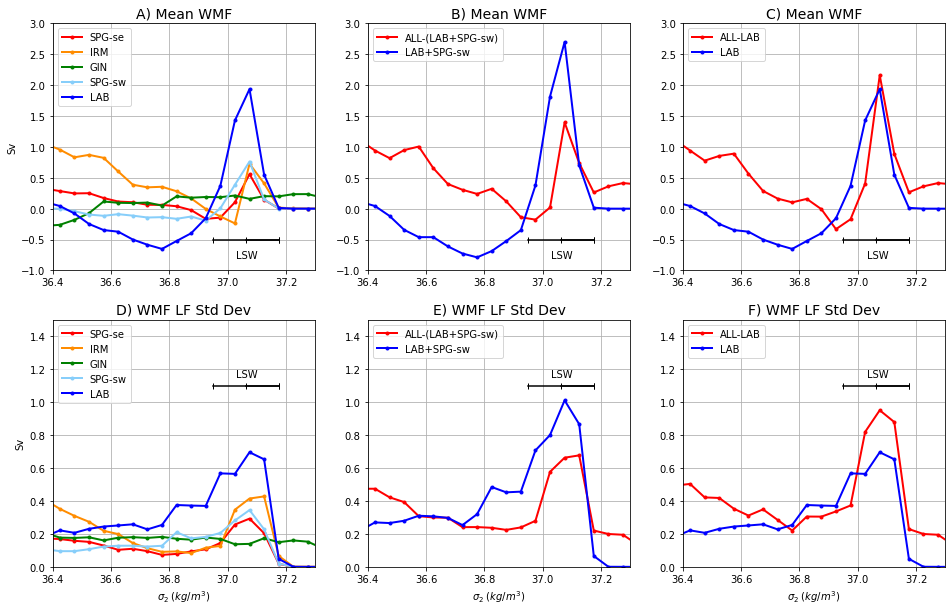

In [15]:
# Mean and Variability of WMT, WMF
fig, ((ax1, ax3, ax5),(ax2,ax4,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
fsize=14

ylat1 = 55.
ylat2 = 45.
ylim1 = [-1,3]
ylim1a = [0,1]
ylim2 = [-6,9]
ylim2a = [0,1.5]
xlim = [36.4,37.3]
legloc = 'upper left'

sigma_wmf = ds3_hr_lpann_dt.sigma_wmf

hr_lsw = [36.95, 37.175]
hr_dlsw = [37.0625, 37.175]
ax1.set_ylabel('Sv')
ax1.set_ylim(ylim1)
ax1.set_xlim(xlim)
ax1.set_title('A) Mean WMF', fontdict={'size':fsize})
labwmf = ds3_hr_lpann_dt.isel(wmf_region=4).mean('time').WMF
labwmfsum = labwmf.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
irmwmf = ds3_hr_lpann_dt.isel(wmf_region=3).mean('time').WMF
irmwmfsum = irmwmf.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
spgwwmf = ds3_hr_lpann_dt.isel(wmf_region=1).mean('time').WMF
spgwwmfsum = spgwwmf.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
spgewmf = ds3_hr_lpann_dt.isel(wmf_region=2).mean('time').WMF
spgewmfsum = spgewmf.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
labspgwmf = ds3_hr_lpann_dt.isel(wmf_region=9).mean('time').WMF
labspgwmfsum = labspgwmf.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
irmspgwmf = ds3_hr_lpann_dt.isel(wmf_region=10).mean('time').WMF
irmspgwmfsum = irmspgwmf.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
ginwmf = ds3_hr_lpann_dt.isel(wmf_region=5).mean('time').WMF
allbutlabwmf = ds3_hr_lpann_dt.isel(wmf_region=7).mean('time').WMF
allbutlabspgwmf = ds3_hr_lpann_dt.isel(wmf_region=11).mean('time').WMF
ax1.plot(sigma_wmf, spgewmf,linewidth=2,marker='.',label='SPG-se',color='r')
ax1.plot(sigma_wmf, irmwmf,linewidth=2,marker='.',label='IRM',color='darkorange')
ax1.plot(sigma_wmf, ginwmf,linewidth=2,marker='.',label='GIN',color='g')
ax1.plot(sigma_wmf, spgwwmf,linewidth=2,marker='.',label='SPG-sw',color='lightskyblue')
ax1.plot(sigma_wmf, labwmf,linewidth=2,marker='.',label='LAB',color='b')
ax1.plot(hr_lsw,[-0.5,-0.5],color='k',marker='|')
ax1.plot(hr_dlsw,[-0.5,-0.5],color='k',marker='|')
ax1.text(37.03,-0.8, 'LSW')
ax1.grid()
ax1.legend(loc=legloc)
#ax1.set_xticklabels([])

ax2.set_ylabel('Sv')
ax2.set_ylim(ylim2a)
ax2.set_xlim(xlim)
ax2.set_title('D) WMF LF Std Dev', fontdict={'size':fsize})
labwmfsd = ds3_hr_lpdtstd.isel(wmf_region=4).WMF
irmwmfsd = ds3_hr_lpdtstd.isel(wmf_region=3).WMF
spgwwmfsd = ds3_hr_lpdtstd.isel(wmf_region=1).WMF
spgewmfsd = ds3_hr_lpdtstd.isel(wmf_region=2).WMF
labspgwmfsd = ds3_hr_lpdtstd.isel(wmf_region=9).WMF
irmspgwmfsd = ds3_hr_lpdtstd.isel(wmf_region=10).WMF
ginwmfsd = ds3_hr_lpdtstd.isel(wmf_region=5).WMF
allbutlabwmfsd = ds3_hr_lpdtstd.isel(wmf_region=7).WMF
allbutlabspgwmfsd = ds3_hr_lpdtstd.isel(wmf_region=11).WMF
ax2.plot(sigma_wmf, spgewmfsd,linewidth=2,marker='.',label='SPG-se',color='r')
ax2.plot(sigma_wmf, irmwmfsd,linewidth=2,marker='.',label='IRM',color='darkorange')
ax2.plot(sigma_wmf, ginwmfsd,linewidth=2,marker='.',label='GIN',color='g')
ax2.plot(sigma_wmf, spgwwmfsd,linewidth=2,marker='.',label='SPG-sw',color='lightskyblue')
ax2.plot(sigma_wmf, labwmfsd,linewidth=2,marker='.',label='LAB',color='b')
ax2.plot(hr_lsw,[1.1,1.1],color='k',marker='|')
ax2.plot(hr_dlsw,[1.1,1.1],color='k',marker='|')
ax2.text(37.03,1.15, 'LSW')
ax2.grid()
ax2.legend(loc=legloc)
ax2.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')
#ax2.set_xticklabels([])

lr_lsw = [36.95, 37.075]
#ax3.set_ylabel('Sv')
ax3.set_ylim(ylim1)
ax3.set_xlim(xlim)
ax3.set_title('B) Mean WMF', fontdict={'size':fsize})
#ax3.plot(sigma_wmf, irmspgwmf,linewidth=2,marker='.',label='IRM+SPG-east',color='r')
ax3.plot(sigma_wmf, allbutlabspgwmf,linewidth=2,marker='.',label='ALL-(LAB+SPG-sw)',color='r')
ax3.plot(sigma_wmf, labspgwmf,linewidth=2,marker='.',label='LAB+SPG-sw',color='b')
ax3.plot(hr_lsw,[-0.5,-0.5],color='k',marker='|')
ax3.plot(hr_dlsw,[-0.5,-0.5],color='k',marker='|')
ax3.text(37.03,-0.8, 'LSW')
ax3.grid()
ax3.legend(loc=legloc)
#ax3.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')

#ax4.set_ylabel('Sv')
ax4.set_ylim(ylim2a)
ax4.set_xlim(xlim)
ax4.set_title('E) WMF LF Std Dev', fontdict={'size':fsize})
#ax4.plot(sigma_wmf, irmspgwmfsd,linewidth=2,marker='.',label='IRM+SPG-east',color='r')
ax4.plot(sigma_wmf, allbutlabspgwmfsd,linewidth=2,marker='.',label='ALL-(LAB+SPG-sw)',color='r')
ax4.plot(sigma_wmf, labspgwmfsd,linewidth=2,marker='.',label='LAB+SPG-sw',color='b')
ax4.plot(hr_lsw,[1.1,1.1],color='k',marker='|')
ax4.plot(hr_dlsw,[1.1,1.1],color='k',marker='|')
ax4.text(37.03,1.15, 'LSW')
ax4.grid()
ax4.legend(loc=legloc)
ax4.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')

lr_lsw = [36.95, 37.075]
#ax5.set_ylabel('Sv')
ax5.set_ylim(ylim1)
ax5.set_xlim(xlim)
ax5.set_title('C) Mean WMF', fontdict={'size':fsize})
ax5.plot(sigma_wmf, allbutlabwmf,linewidth=2,marker='.',label='ALL-LAB',color='r')
ax5.plot(sigma_wmf, labwmf,linewidth=2,marker='.',label='LAB',color='b')
ax5.plot(hr_lsw,[-0.5,-0.5],color='k',marker='|')
ax5.plot(hr_dlsw,[-0.5,-0.5],color='k',marker='|')
ax5.text(37.03,-0.8, 'LSW')
ax5.grid()
ax5.legend(loc=legloc)
#ax5.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')

#ax6.set_ylabel('Sv')
ax6.set_ylim(ylim2a)
ax6.set_xlim(xlim)
ax6.set_title('F) WMF LF Std Dev', fontdict={'size':fsize})
ax6.plot(sigma_wmf, allbutlabwmfsd,linewidth=2,marker='.',label='ALL-LAB',color='r')
ax6.plot(sigma_wmf, labwmfsd,linewidth=2,marker='.',label='LAB',color='b')
ax6.plot(hr_lsw,[1.1,1.1],color='k',marker='|')
ax6.plot(hr_dlsw,[1.1,1.1],color='k',marker='|')
ax6.text(37.03,1.15, 'LSW')
ax6.grid()
ax6.legend(loc=legloc)
ax6.set_xlabel(r'$\sigma_2\; (kg/m^{3})$')

plt.savefig('Fig_4.pdf')

# Table 1 values

## Formation Mean

In [51]:
hr_lsw

[36.95, 37.175]

In [52]:
hr_dlsw = [(hr_lsw[1]-hr_lsw[0])*0.5 +hr_lsw[0], hr_lsw[1]]
hr_dlsw

[37.0625, 37.175]

In [53]:
meanlsw = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
meanlsw = meanlsw.mean('time')

In [54]:
print("MEAN LSW")
for i in range(meanlsw.wmf_region.size):
    print("{} : {:10.2f}".format(meanlsw.wmf_region.values[i], meanlsw.values[i]))

MEAN LSW
All (>0) :       7.85
SPG_west (1) :       1.31
SPG_east (2) :       0.67
Irminger Sea (3) :       0.79
Labrador Sea (4) :       4.30
Norwegian Sea (5) :       0.96
Arctic (6) :      -0.19
ALL minus LAB (7) :       3.55
IRM+SPG (8) :       2.77
LAB+SPG-west (9) :       5.61
IRM+SPG-east (10) :       1.46
ALL minus LAB+SPG-west (11) :       2.24


In [55]:
5.61/7.85

0.7146496815286625

In [56]:
# test for normality
print("Is LSW WMF normally distributed?")
alpha = 0.05
for i in range(meanlsw.wmf_region.size):
    x1 = ds3_hr_ann_dt.WMF.isel(wmf_region=i).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
    mean = x1.mean('time')
    #D, p = stats.shapiro(x1)
    #D, p = stats.kstest(x1,'norm')
    D, p = stats.normaltest(x1)
    if (p>=alpha): 
        norm="True" 
    else: 
        norm="False"
    print("{} : {}: {}: {}".format(meanlsw.wmf_region.values[i], mean.values, p, norm))

Is LSW WMF normally distributed?
All (>0) : 7.8496012687683105: 0.3117499817513819: True
SPG_west (1) : 1.3107932806015015: 0.00012524101747473962: False
SPG_east (2) : 0.6691458821296692: 1.123785392451955e-07: False
Irminger Sea (3) : 0.7938430905342102: 0.03284722731971476: False
Labrador Sea (4) : 4.296127796173096: 0.4302885219131908: True
Norwegian Sea (5) : 0.9653928875923157: 0.658142505516073: True
Arctic (6) : -0.1857687383890152: 0.6739894935055448: True
ALL minus LAB (7) : 3.5534067153930664: 0.6718147480898826: True
IRM+SPG (8) : 2.773782253265381: 0.0029619411941039587: False
LAB+SPG-west (9) : 5.606922149658203: 0.26294550497652924: True
IRM+SPG-east (10) : 1.4629889726638794: 0.011665286238051577: False
ALL minus LAB+SPG-west (11) : 2.242612600326538: 0.24279731610695787: True


In [57]:
# Welch's t-test to test for different means:
# Null hypothesis: samples have identical means
print("LAB vs. (ALL-LAB)")
alpha = 0.05
x1 = ds3_hr_ann_dt.WMF.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf').isel(wmf_region=4)
x2 = ds3_hr_ann_dt.WMF.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf').isel(wmf_region=7)
D, p = stats.ttest_ind(x1,x2,equal_var=False)
if (p>=alpha): 
    result="Regions have the same mean" 
else: 
    result="Regions have different mean"
print("p={} : {}".format(p, result))

LAB vs. (ALL-LAB)
p=6.5192095087460405e-12 : Regions have different mean


In [58]:
# Welch's t-test to test for different means:
# Null hypothesis: samples have identical means
print("LAB+SPG-west vs. (ALL-LAB+SPG-west)")
alpha = 0.05
x1 = ds3_hr_ann_dt.WMF.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf').isel(wmf_region=9)
x2 = ds3_hr_ann_dt.WMF.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf').isel(wmf_region=11)
D, p = stats.ttest_ind(x1,x2,equal_var=False)
if (p>=alpha): 
    result="Regions have the same mean" 
else: 
    result="Regions have different mean"
print("p={} : {}".format(p, result))

LAB+SPG-west vs. (ALL-LAB+SPG-west)
p=6.305628605491549e-115 : Regions have different mean


In [59]:
hr_dlsw = [(hr_lsw[1]-hr_lsw[0])*0.5 +hr_lsw[0], hr_lsw[1]]
meandlsw = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
meandlsw = meandlsw.mean('time')

In [60]:
print("MEAN dLSW")
for i in range(meandlsw.wmf_region.size):
    print("{} : {:10.2f}".format(meandlsw.wmf_region.values[i], meandlsw.values[i]))

MEAN dLSW
All (>0) :       5.82
SPG_west (1) :       0.92
SPG_east (2) :       0.71
Irminger Sea (3) :       1.16
Labrador Sea (4) :       2.50
Norwegian Sea (5) :       0.56
Arctic (6) :      -0.03
ALL minus LAB (7) :       3.31
IRM+SPG (8) :       2.78
LAB+SPG-west (9) :       3.42
IRM+SPG-east (10) :       1.87
ALL minus LAB+SPG-west (11) :       2.40


In [61]:
3.42/5.82

0.5876288659793814

In [62]:
# test for normality
print("dLSW WMF normally distributed?")
alpha = 0.05
for i in range(meandlsw.wmf_region.size):
    x1 = ds3_hr_ann_dt.WMF.isel(wmf_region=i).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
    mean = x1.mean('time')
    D, p = stats.shapiro(x1)
    #D, p = stats.normaltest(x1)
    if (p>=alpha): 
        norm="True" 
    else: 
        norm="False"
    print("{} : {}: {}: {}".format(meandlsw.wmf_region.values[i], mean.values, p, norm))

dLSW WMF normally distributed?
All (>0) : 5.817356109619141: 1.0938979357888456e-06: False
SPG_west (1) : 0.9161280393600464: 6.107232775054428e-11: False
SPG_east (2) : 0.7087029218673706: 1.826840978838562e-12: False
Irminger Sea (3) : 1.1575684547424316: 1.2270733122932143e-06: False
Labrador Sea (4) : 2.500304937362671: 2.0760842289746506e-07: False
Norwegian Sea (5) : 0.5648283362388611: 0.9572058320045471: True
Arctic (6) : -0.030182521790266037: 0.7389059662818909: True
ALL minus LAB (7) : 3.3170454502105713: 5.938991307630204e-07: False
IRM+SPG (8) : 2.7823994159698486: 8.314824384569874e-09: False
LAB+SPG-west (9) : 3.4164340496063232: 4.015182142325102e-08: False
IRM+SPG-east (10) : 1.8662716150283813: 5.137874481420113e-08: False
ALL minus LAB+SPG-west (11) : 2.400916814804077: 5.152928861207329e-05: False


In [63]:
# test for normality
print("dLSW WMF normally distributed?")
alpha = 0.05
i=5
x1 = ds3_hr_ann_dt.WMF.isel(wmf_region=i).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
mean = x1.mean('time')
stat,crit,sign= stats.anderson(x1.values)
#results.statistic,results.critical_values,results.significance_level
stat, crit, sign

dLSW WMF normally distributed?


(0.18005413633613898,
 array([0.569, 0.648, 0.777, 0.906, 1.078]),
 array([15. , 10. ,  5. ,  2.5,  1. ]))

In [64]:
# Welch's t-test to test for different means:
# Null hypothesis: samples have identical means
print("LAB vs. (ALL-LAB)")
alpha = 0.05
x1 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf').isel(wmf_region=4)
x2 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf').isel(wmf_region=7)
D, p = stats.ttest_ind(x1,x2,equal_var=False)
if (p>=alpha): 
    result="Regions have the same mean" 
else: 
    result="Regions have different mean"
print("p={} : {}".format(p, result))

LAB vs. (ALL-LAB)
p=3.8667280200449665e-17 : Regions have different mean


In [65]:
# Welch's t-test to test for different means:
# Null hypothesis: samples have identical means
print("LAB+SPG-west vs. (ALL-LAB+SPG-west)")
alpha = 0.05
x1 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf').isel(wmf_region=9)
x2 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf').isel(wmf_region=11)
D, p = stats.ttest_ind(x1,x2,equal_var=False)
if (p>=alpha): 
    result="Regions have the same mean" 
else: 
    result="Regions have different mean"
print("p={} : {}".format(p, result))

LAB+SPG-west vs. (ALL-LAB+SPG-west)
p=2.811494450206955e-23 : Regions have different mean


## Formation LF Variability

In [66]:
sdlsw = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
sdlsw = sdlsw.std('time')

In [67]:
print("LF STD DEV LSW")
for i in range(sdlsw.wmf_region.size):
    print("{} : {:13.5f}".format(sdlsw.wmf_region.values[i], sdlsw.values[i]))

LF STD DEV LSW
All (>0) :       0.99232
SPG_west (1) :       0.26569
SPG_east (2) :       0.16832
Irminger Sea (3) :       0.16822
Labrador Sea (4) :       0.55947
Norwegian Sea (5) :       0.26363
Arctic (6) :       0.17752
ALL minus LAB (7) :       0.52666
IRM+SPG (8) :       0.52371
LAB+SPG-west (9) :       0.78230
IRM+SPG-east (10) :       0.30468
ALL minus LAB+SPG-west (11) :       0.36320


In [68]:
# Levene's to test for differences in variance:
# Null hypothesis: samples have identical variance
print("LSW:  LAB vs. (ALL-LAB)")
alpha = 0.05
x1 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf').isel(wmf_region=4)
x2 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf').isel(wmf_region=7)
D, p = stats.levene(x1,x2)
if (p>=alpha): 
    result="Regions have the same variance" 
else: 
    result="Regions have different variance"
print("p={} : {}".format(p, result))

LSW:  LAB vs. (ALL-LAB)
p=0.19368028525262637 : Regions have the same variance


In [69]:
# Levene's to test for differences in variance:
# Null hypothesis: samples have identical variance
print("LSW:  LAB+SPG-west vs. (ALL-LAB+SPG-west)")
alpha = 0.05
x1 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf').isel(wmf_region=9)
x2 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf').isel(wmf_region=11)
D, p = stats.levene(x1,x2)
if (p>=alpha): 
    result="Regions have the same variance" 
else: 
    result="Regions have different variance"
print("p={} : {}".format(p, result))

LSW:  LAB+SPG-west vs. (ALL-LAB+SPG-west)
p=3.377569035602758e-33 : Regions have different variance


In [70]:
sddlsw = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
sddlsw = sddlsw.std('time')

In [71]:
print("STD DEV dLSW")
for i in range(sddlsw.wmf_region.size):
    x1 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
    D, p = stats.shapiro(x1)
    print("{} : {:10.2f}".format(sddlsw.wmf_region.values[i], sddlsw.values[i]))

STD DEV dLSW
All (>0) :       2.23
SPG_west (1) :       0.43
SPG_east (2) :       0.37
Irminger Sea (3) :       0.48
Labrador Sea (4) :       1.05
Norwegian Sea (5) :       0.21
Arctic (6) :       0.18
ALL minus LAB (7) :       1.24
IRM+SPG (8) :       1.21
LAB+SPG-west (9) :       1.46
IRM+SPG-east (10) :       0.82
ALL minus LAB+SPG-west (11) :       0.85


In [72]:
# Levene's to test for differences in variance:
# Null hypothesis: samples have identical variance
print("dLSW:  LAB vs. (ALL-LAB)")
alpha = 0.05
x1 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf').isel(wmf_region=4)
x2 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf').isel(wmf_region=7)
D, p = stats.levene(x1,x2)
if (p>=alpha): 
    result="Regions have the same variance" 
else: 
    result="Regions have different variance"
print("p={} : {}".format(p, result))

dLSW:  LAB vs. (ALL-LAB)
p=0.003372836282617322 : Regions have different variance


In [73]:
# Levene's to test for differences in variance:
# Null hypothesis: samples have identical variance
print("dLSW:  LAB+SPG-west vs. (ALL-LAB+SPG-west)")
alpha = 0.05
x1 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf').isel(wmf_region=9)
x2 = ds3_hr_lpann_dt.WMF.sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf').isel(wmf_region=11)
D, p = stats.levene(x1,x2)
if (p>=alpha): 
    result="Regions have the same variance" 
else: 
    result="Regions have different variance"
print("p={} : {}".format(p, result))

dLSW:  LAB+SPG-west vs. (ALL-LAB+SPG-west)
p=1.6512393450946943e-19 : Regions have different variance


### Correlations

In [74]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backward. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        #x   = x.shift(time = -lagx).dropna(dim='time')
        if lagx>0: x = x.shift(time = -lagx).isel(time=slice(0,-lagx))
        if lagx<0: x = x.shift(time = -lagx).isel(time=slice(-lagx,None))

        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        #y   = y.shift(time = -lagy).dropna(dim='time')
        if lagy>0: y = y.shift(time = -lagy).isel(time=slice(0,-lagy))
        if lagy<0: y = y.shift(time = -lagy).isel(time=slice(-lagy,None))
        x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    #cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    cov   = ((x - xmean) * (y - ymean)).mean(axis=0)

    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #6.5. Compute effective degrees of freedom taking into account autocorrelation
    xp1 = x.shift(time=-1).isel(time=slice(0,-1))
    xtmp,xp1 = xr.align(x,xp1)
    autocorrx = xr.corr(xtmp,xp1,dim='time')
    yp1 = y.shift(time=-1).isel(time=slice(0,-1))
    ytmp,yp1 = xr.align(y,yp1)
    autocorry = xr.corr(ytmp,yp1,dim='time')
    neff = n*(1-autocorrx*autocorry)/(1+autocorrx*autocorry)

    #7. Compute P-value and standard error
    #Compute t-statistics
    #tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    tstats = cor*np.sqrt(neff-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats

    from scipy.stats import t
    #pval   = t.sf(tstats, neff-2)*2
    pval = 2.*(1-t.cdf(np.abs(slope/stderr),neff-2))
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)
    
    #8. Combine all stats into single output xarray
    stat = xr.DataArray(['covariance','correlation','slope','intercept','pval','stderr'],dims="stat",name="stat")
    xrout = xr.concat([cov,cor,slope,intercept,pval,stderr],dim=stat)

    return xrout

In [75]:
def concat_correlations(x, y, lagyrange):
    corrlist = []
    lag = xr.DataArray([i for i in lagyrange],dims='lag',name='lag')
    for i in lagyrange:
        z = lag_linregress_3D(x,y,lagy=i)
#        z.name = y.name + '_corr_'+x.name
        corrlist.append(z)
    return xr.concat(corrlist,dim=lag)

# fig S4

In [76]:
ds3_hr_lpann_dt.wmf_region

<xarray.DataArray 'wmf_region' (wmf_region: 12)>
array(['All (>0)', 'SPG_west (1)', 'SPG_east (2)', 'Irminger Sea (3)',
       'Labrador Sea (4)', 'Norwegian Sea (5)', 'Arctic (6)',
       'ALL minus LAB (7)', 'IRM+SPG (8)', 'LAB+SPG-west (9)',
       'IRM+SPG-east (10)', 'ALL minus LAB+SPG-west (11)'], dtype=object)
Coordinates:
  * wmf_region  (wmf_region) object 'All (>0)' ... 'ALL minus LAB+SPG-west (11)'

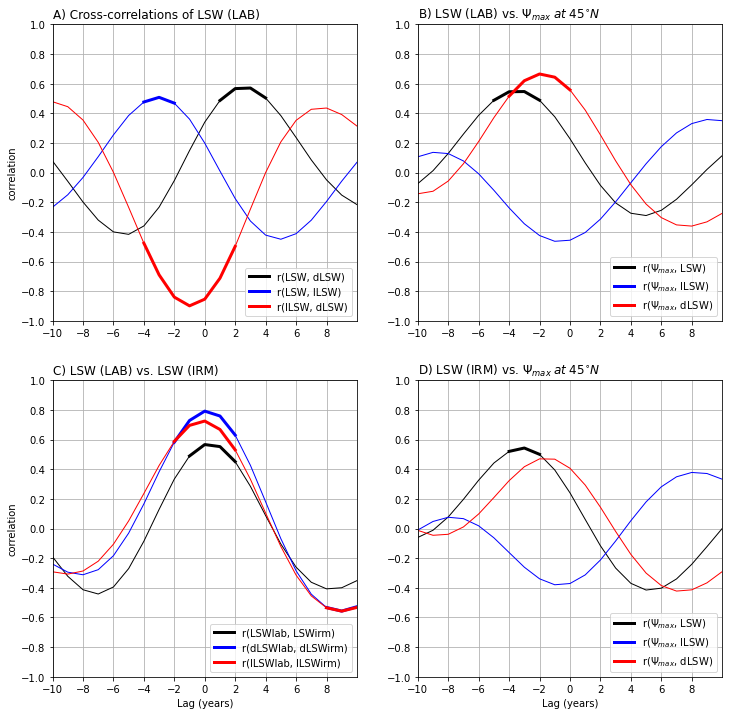

In [35]:
lagrange = range(-10,11,1)
moc45 = ds2_hr_lpann_dt.MOCsig.isel(transport_reg=1).isel(moc_comp=0).sel(lat_aux_grid=45.,method='nearest').max('moc_s')
lswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
dlswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
llswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_lsw[0],hr_dlsw[0])).sum('sigma_wmf')
xcorr1 = concat_correlations(lswwmf,dlswwmf, lagrange)
xcorr2 = concat_correlations(lswwmf,llswwmf, lagrange)
xcorr3 = concat_correlations(llswwmf,dlswwmf, lagrange)
xcorr4 = concat_correlations(moc45,lswwmf, lagrange)
xcorr5 = concat_correlations(moc45,llswwmf, lagrange)
xcorr6 = concat_correlations(moc45,dlswwmf, lagrange)

# Year 200-500 hovmuller plots
fig = plt.figure(figsize=(12, 12))
spec = fig.add_gridspec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])

xlim=[-10,10]
ylim=[-1.,1]
yticks = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
xticks = np.arange(-10,10,2)
fsize=12
lw = 0.5
siglvl = 0.05

#ax1.set_xlabel('Lag (years)')
ax1.set_ylabel('correlation')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.set_title(r'A) Cross-correlations of LSW (LAB)', fontdict={'size':fsize}, loc='left')
plt1a = ax1.plot(xcorr1.lag, xcorr1.sel(stat='correlation'),color='k',linewidth=1)
work1b = xcorr1.where(xcorr1.sel(stat='pval') < siglvl)
plt1b = ax1.plot(work1b.lag,work1b.sel(stat='correlation'), color='k', linewidth=3,label=r'r(LSW, dLSW)')
plt1c = ax1.plot(xcorr2.lag, xcorr2.sel(stat='correlation'),color='b',linewidth=1)
work1d = xcorr2.where(xcorr2.sel(stat='pval') < siglvl)
plt1d = ax1.plot(work1d.lag,work1d.sel(stat='correlation'), color='b', linewidth=3,label=r'r(LSW, lLSW)')
plt1e = ax1.plot(xcorr3.lag, xcorr3.sel(stat='correlation'),color='r',linewidth=1)
work1f = xcorr3.where(xcorr3.sel(stat='pval') < siglvl)
plt1f = ax1.plot(work1f.lag,work1f.sel(stat='correlation'), color='r', linewidth=3,label=r'r(lLSW, dLSW)')
ax1.grid()
ax1.set_yticks(yticks)
ax1.set_xticks(xticks)
ax1.legend(loc='lower right')

#ax2.set_xlabel('Lag (years)')
#ax2.set_ylabel('correlation')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)
tmpstr = r'$\Psi_{max} \; at \; 45^{\circ}N$'
ax2.set_title(r'B) LSW (LAB) vs. '+tmpstr, fontdict={'size':fsize}, loc='left')
plt2a = ax2.plot(xcorr4.lag, xcorr4.sel(stat='correlation'),color='k',linewidth=1)
work2b = xcorr4.where(xcorr4.sel(stat='pval') < siglvl)
lab2b = r'r($\Psi_{max}$, LSW)'
plt2b = ax2.plot(work2b.lag,work2b.sel(stat='correlation'), color='k', linewidth=3,label=lab2b)
plt2c = ax2.plot(xcorr5.lag, xcorr5.sel(stat='correlation'),color='b',linewidth=1)
work2d = xcorr5.where(xcorr5.sel(stat='pval') < siglvl)
lab2c = r'r($\Psi_{max}$, lLSW)'
plt2d = ax2.plot(work2d.lag,work2d.sel(stat='correlation'), color='b', linewidth=3,label=lab2c)
plt2e = ax2.plot(xcorr6.lag, xcorr6.sel(stat='correlation'),color='r',linewidth=1)
work2f = xcorr6.where(xcorr6.sel(stat='pval') < siglvl)
lab2d = r'r($\Psi_{max}$, dLSW)'
plt2f = ax2.plot(work2f.lag,work2f.sel(stat='correlation'), color='r', linewidth=3,label=lab2d)
ax2.grid()
ax2.set_yticks(yticks)
ax2.set_xticks(xticks)
ax2.legend(loc='lower right')

#lswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
#dlswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
#llswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_lsw[0],hr_dlsw[0])).sum('sigma_wmf')
lswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=3).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
dlswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=3).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
llswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=3).sel(sigma_wmf=slice(hr_lsw[0],hr_dlsw[0])).sum('sigma_wmf')
xcorr1 = concat_correlations(lswwmf,lswwmf2, lagrange)
xcorr2 = concat_correlations(dlswwmf,dlswwmf2, lagrange)
xcorr3 = concat_correlations(llswwmf,llswwmf2, lagrange)
#lswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=10).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
#dlswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=10).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
#llswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=10).sel(sigma_wmf=slice(hr_lsw[0],hr_dlsw[0])).sum('sigma_wmf')
xcorr4 = concat_correlations(moc45,lswwmf2, lagrange)
xcorr5 = concat_correlations(moc45,llswwmf2, lagrange)
xcorr6 = concat_correlations(moc45,dlswwmf2, lagrange)

ax3.set_ylabel('correlation')
ax3.set_xlabel('Lag (years)')
ax3.set_ylim(ylim)
ax3.set_xlim(xlim)
ax3.set_title(r'C) LSW (LAB) vs. LSW (IRM)', fontdict={'size':fsize}, loc='left')
plt3a = ax3.plot(xcorr1.lag, xcorr1.sel(stat='correlation'),color='k',linewidth=1)
work3b = xcorr1.where(xcorr1.sel(stat='pval') < siglvl)
plt3b = ax3.plot(work3b.lag,work3b.sel(stat='correlation'), color='k', linewidth=3,label=r'r(LSWlab, LSWirm)')
plt3c = ax3.plot(xcorr2.lag, xcorr2.sel(stat='correlation'),color='b',linewidth=1)
work3d = xcorr2.where(xcorr2.sel(stat='pval') < siglvl)
plt3d = ax3.plot(work3d.lag,work3d.sel(stat='correlation'), color='b', linewidth=3,label=r'r(dLSWlab, dLSWirm)')
plt3e = ax3.plot(xcorr3.lag, xcorr3.sel(stat='correlation'),color='r',linewidth=1)
work3e = xcorr3.where(xcorr3.sel(stat='pval') < siglvl)
plt3f = ax3.plot(work3e.lag,work3e.sel(stat='correlation'), color='r', linewidth=3,label=r'r(lLSWlab, lLSWirm)')
ax3.grid()
ax3.set_yticks(yticks)
ax3.set_xticks(xticks)
ax3.legend(loc='lower right')

ax4.set_xlabel('Lag (years)')
#ax4.set_ylabel('correlation')
ax4.set_ylim(ylim)
ax4.set_xlim(xlim)
tmpstr = r'$\Psi_{max} \; at \; 45^{\circ}N$'
ax4.set_title(r'D) LSW (IRM) vs. '+tmpstr, fontdict={'size':fsize}, loc='left')
plt4a = ax4.plot(xcorr4.lag, xcorr4.sel(stat='correlation'),color='k',linewidth=1)
work4b = xcorr4.where(xcorr4.sel(stat='pval') < siglvl)
lab4b = r'r($\Psi_{max}$, LSW)'
plt4b = ax4.plot(work4b.lag,work4b.sel(stat='correlation'), color='k', linewidth=3,label=lab4b)
plt4c = ax4.plot(xcorr5.lag, xcorr5.sel(stat='correlation'),color='b',linewidth=1)
work4d = xcorr5.where(xcorr5.sel(stat='pval') < siglvl)
lab4c = r'r($\Psi_{max}$, lLSW)'
plt4d = ax4.plot(work4d.lag,work4d.sel(stat='correlation'), color='b', linewidth=3,label=lab4c)
plt4e = ax4.plot(xcorr6.lag, xcorr6.sel(stat='correlation'),color='r',linewidth=1)
work4f = xcorr6.where(xcorr6.sel(stat='pval') < siglvl)
lab4d = r'r($\Psi_{max}$, dLSW)'
plt4f = ax4.plot(work4f.lag,work4f.sel(stat='correlation'), color='r', linewidth=3,label=lab4d)
ax4.grid()
ax4.set_yticks(yticks)
ax4.set_xticks(xticks)
ax4.legend(loc='lower right')

#plt.savefig('fig_S5.pdf')

In [82]:
ds3_hr_lpann_dt.wmf_region

<xarray.DataArray 'wmf_region' (wmf_region: 12)>
array(['All (>0)', 'SPG_west (1)', 'SPG_east (2)', 'Irminger Sea (3)',
       'Labrador Sea (4)', 'Norwegian Sea (5)', 'Arctic (6)',
       'ALL minus LAB (7)', 'IRM+SPG (8)', 'LAB+SPG-west (9)',
       'IRM+SPG-east (10)', 'ALL minus LAB+SPG-west (11)'], dtype=object)
Coordinates:
  * wmf_region  (wmf_region) object 'All (>0)' ... 'ALL minus LAB+SPG-west (11)'

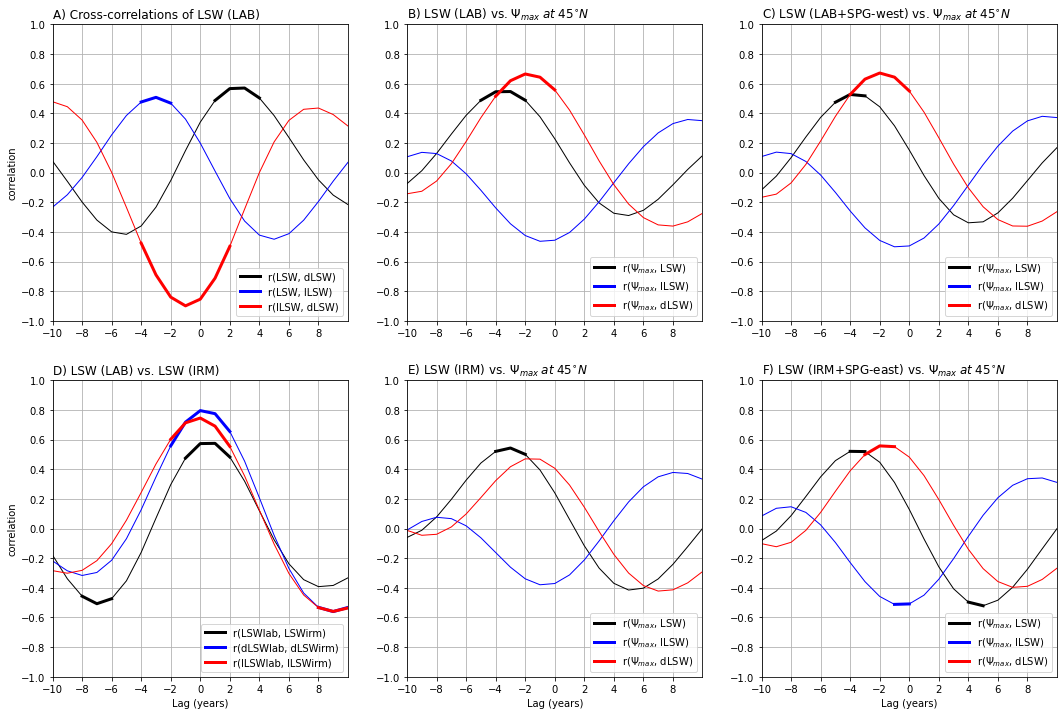

In [84]:
lagrange = range(-10,11,1)
moc45 = ds2_hr_lpann_dt.MOCsig.isel(transport_reg=1).isel(moc_comp=0).sel(lat_aux_grid=45.,method='nearest').max('moc_s')
lswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
dlswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
llswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_lsw[0],hr_dlsw[0])).sum('sigma_wmf')
xcorr1 = concat_correlations(lswwmf,dlswwmf, lagrange)
xcorr2 = concat_correlations(lswwmf,llswwmf, lagrange)
xcorr3 = concat_correlations(llswwmf,dlswwmf, lagrange)
xcorr4 = concat_correlations(moc45,lswwmf, lagrange)
xcorr5 = concat_correlations(moc45,llswwmf, lagrange)
xcorr6 = concat_correlations(moc45,dlswwmf, lagrange)

# Year 200-500 hovmuller plots
fig = plt.figure(figsize=(18, 12))
spec = fig.add_gridspec(ncols=3, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[0, 2])
ax4 = fig.add_subplot(spec[1, 0])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[1, 2])

xlim=[-10,10]
ylim=[-1.,1]
yticks = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]
xticks = np.arange(-10,10,2)
fsize=12
lw = 0.5
siglvl = 0.05

#ax1.set_xlabel('Lag (years)')
ax1.set_ylabel('correlation')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.set_title(r'A) Cross-correlations of LSW (LAB)', fontdict={'size':fsize}, loc='left')
plt1a = ax1.plot(xcorr1.lag, xcorr1.sel(stat='correlation'),color='k',linewidth=1)
work1b = xcorr1.where(xcorr1.sel(stat='pval') < siglvl)
plt1b = ax1.plot(work1b.lag,work1b.sel(stat='correlation'), color='k', linewidth=3,label=r'r(LSW, dLSW)')
plt1c = ax1.plot(xcorr2.lag, xcorr2.sel(stat='correlation'),color='b',linewidth=1)
work1d = xcorr2.where(xcorr2.sel(stat='pval') < siglvl)
plt1d = ax1.plot(work1d.lag,work1d.sel(stat='correlation'), color='b', linewidth=3,label=r'r(LSW, lLSW)')
plt1e = ax1.plot(xcorr3.lag, xcorr3.sel(stat='correlation'),color='r',linewidth=1)
work1f = xcorr3.where(xcorr3.sel(stat='pval') < siglvl)
plt1f = ax1.plot(work1f.lag,work1f.sel(stat='correlation'), color='r', linewidth=3,label=r'r(lLSW, dLSW)')
ax1.grid()
ax1.set_yticks(yticks)
ax1.set_xticks(xticks)
ax1.legend(loc='lower right')

#ax2.set_xlabel('Lag (years)')
#ax2.set_ylabel('correlation')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)
tmpstr = r'$\Psi_{max} \; at \; 45^{\circ}N$'
ax2.set_title(r'B) LSW (LAB) vs. '+tmpstr, fontdict={'size':fsize}, loc='left')
plt2a = ax2.plot(xcorr4.lag, xcorr4.sel(stat='correlation'),color='k',linewidth=1)
work2b = xcorr4.where(xcorr4.sel(stat='pval') < siglvl)
lab2b = r'r($\Psi_{max}$, LSW)'
plt2b = ax2.plot(work2b.lag,work2b.sel(stat='correlation'), color='k', linewidth=3,label=lab2b)
plt2c = ax2.plot(xcorr5.lag, xcorr5.sel(stat='correlation'),color='b',linewidth=1)
work2d = xcorr5.where(xcorr5.sel(stat='pval') < siglvl)
lab2c = r'r($\Psi_{max}$, lLSW)'
plt2d = ax2.plot(work2d.lag,work2d.sel(stat='correlation'), color='b', linewidth=3,label=lab2c)
plt2e = ax2.plot(xcorr6.lag, xcorr6.sel(stat='correlation'),color='r',linewidth=1)
work2f = xcorr6.where(xcorr6.sel(stat='pval') < siglvl)
lab2d = r'r($\Psi_{max}$, dLSW)'
plt2f = ax2.plot(work2f.lag,work2f.sel(stat='correlation'), color='r', linewidth=3,label=lab2d)
ax2.grid()
ax2.set_yticks(yticks)
ax2.set_xticks(xticks)
ax2.legend(loc='lower right')

lswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=9).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
dlswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=9).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
llswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=9).sel(sigma_wmf=slice(hr_lsw[0],hr_dlsw[0])).sum('sigma_wmf')
xcorr4 = concat_correlations(moc45,lswwmf, lagrange)
xcorr5 = concat_correlations(moc45,llswwmf, lagrange)
xcorr6 = concat_correlations(moc45,dlswwmf, lagrange)
ax3.set_ylim(ylim)
ax3.set_xlim(xlim)
tmpstr = r'$\Psi_{max} \; at \; 45^{\circ}N$'
ax3.set_title(r'C) LSW (LAB+SPG-west) vs. '+tmpstr, fontdict={'size':fsize}, loc='left')
plt3a = ax3.plot(xcorr4.lag, xcorr4.sel(stat='correlation'),color='k',linewidth=1)
work3b = xcorr4.where(xcorr4.sel(stat='pval') < siglvl)
lab3b = r'r($\Psi_{max}$, LSW)'
plt3b = ax3.plot(work3b.lag,work3b.sel(stat='correlation'), color='k', linewidth=3,label=lab3b)
plt3c = ax3.plot(xcorr5.lag, xcorr5.sel(stat='correlation'),color='b',linewidth=1)
work3d = xcorr5.where(xcorr5.sel(stat='pval') < siglvl)
lab3c = r'r($\Psi_{max}$, lLSW)'
plt3d = ax3.plot(work3d.lag,work3d.sel(stat='correlation'), color='b', linewidth=3,label=lab3c)
plt3e = ax3.plot(xcorr6.lag, xcorr6.sel(stat='correlation'),color='r',linewidth=1)
work3f = xcorr6.where(xcorr6.sel(stat='pval') < siglvl)
lab3d = r'r($\Psi_{max}$, dLSW)'
plt3f = ax3.plot(work3f.lag,work3f.sel(stat='correlation'), color='r', linewidth=3,label=lab3d)
ax3.grid()
ax3.set_yticks(yticks)
ax3.set_xticks(xticks)
ax3.legend(loc='lower right')


#lswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
#dlswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
#llswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=4).sel(sigma_wmf=slice(hr_lsw[0],hr_dlsw[0])).sum('sigma_wmf')
lswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=3).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
dlswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=3).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
llswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=3).sel(sigma_wmf=slice(hr_lsw[0],hr_dlsw[0])).sum('sigma_wmf')
xcorr1 = concat_correlations(lswwmf,lswwmf2, lagrange)
xcorr2 = concat_correlations(dlswwmf,dlswwmf2, lagrange)
xcorr3 = concat_correlations(llswwmf,llswwmf2, lagrange)
#lswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=10).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
#dlswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=10).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
#llswwmf2 = ds3_hr_lpann_dt.WMF.isel(wmf_region=10).sel(sigma_wmf=slice(hr_lsw[0],hr_dlsw[0])).sum('sigma_wmf')
xcorr4 = concat_correlations(moc45,lswwmf2, lagrange)
xcorr5 = concat_correlations(moc45,llswwmf2, lagrange)
xcorr6 = concat_correlations(moc45,dlswwmf2, lagrange)

ax4.set_ylabel('correlation')
ax4.set_xlabel('Lag (years)')
ax4.set_ylim(ylim)
ax4.set_xlim(xlim)
ax4.set_title(r'D) LSW (LAB) vs. LSW (IRM)', fontdict={'size':fsize}, loc='left')
plt4a = ax4.plot(xcorr1.lag, xcorr1.sel(stat='correlation'),color='k',linewidth=1)
work4b = xcorr1.where(xcorr1.sel(stat='pval') < siglvl)
plt4b = ax4.plot(work4b.lag,work4b.sel(stat='correlation'), color='k', linewidth=3,label=r'r(LSWlab, LSWirm)')
plt4c = ax4.plot(xcorr2.lag, xcorr2.sel(stat='correlation'),color='b',linewidth=1)
work4d = xcorr2.where(xcorr2.sel(stat='pval') < siglvl)
plt4d = ax4.plot(work4d.lag,work4d.sel(stat='correlation'), color='b', linewidth=3,label=r'r(dLSWlab, dLSWirm)')
plt4e = ax4.plot(xcorr3.lag, xcorr3.sel(stat='correlation'),color='r',linewidth=1)
work4e = xcorr3.where(xcorr3.sel(stat='pval') < siglvl)
plt4f = ax4.plot(work4e.lag,work4e.sel(stat='correlation'), color='r', linewidth=3,label=r'r(lLSWlab, lLSWirm)')
ax4.grid()
ax4.set_yticks(yticks)
ax4.set_xticks(xticks)
ax4.legend(loc='lower right')

ax5.set_xlabel('Lag (years)')
ax5.set_ylim(ylim)
ax5.set_xlim(xlim)
tmpstr = r'$\Psi_{max} \; at \; 45^{\circ}N$'
ax5.set_title(r'E) LSW (IRM) vs. '+tmpstr, fontdict={'size':fsize}, loc='left')
plt5a = ax5.plot(xcorr4.lag, xcorr4.sel(stat='correlation'),color='k',linewidth=1)
work5b = xcorr4.where(xcorr4.sel(stat='pval') < siglvl)
lab5b = r'r($\Psi_{max}$, LSW)'
plt5b = ax5.plot(work5b.lag,work5b.sel(stat='correlation'), color='k', linewidth=3,label=lab4b)
plt5c = ax5.plot(xcorr5.lag, xcorr5.sel(stat='correlation'),color='b',linewidth=1)
work5d = xcorr5.where(xcorr5.sel(stat='pval') < siglvl)
lab5c = r'r($\Psi_{max}$, lLSW)'
plt5d = ax5.plot(work5d.lag,work5d.sel(stat='correlation'), color='b', linewidth=3,label=lab4c)
plt5e = ax5.plot(xcorr6.lag, xcorr6.sel(stat='correlation'),color='r',linewidth=1)
work5f = xcorr6.where(xcorr6.sel(stat='pval') < siglvl)
lab5d = r'r($\Psi_{max}$, dLSW)'
plt5f = ax5.plot(work5f.lag,work5f.sel(stat='correlation'), color='r', linewidth=3,label=lab4d)
ax5.grid()
ax5.set_yticks(yticks)
ax5.set_xticks(xticks)
ax5.legend(loc='lower right')

lswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=10).sel(sigma_wmf=slice(hr_lsw[0],hr_lsw[1])).sum('sigma_wmf')
dlswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=10).sel(sigma_wmf=slice(hr_dlsw[0],hr_dlsw[1])).sum('sigma_wmf')
llswwmf = ds3_hr_lpann_dt.WMF.isel(wmf_region=10).sel(sigma_wmf=slice(hr_lsw[0],hr_dlsw[0])).sum('sigma_wmf')
xcorr4 = concat_correlations(moc45,lswwmf, lagrange)
xcorr5 = concat_correlations(moc45,llswwmf, lagrange)
xcorr6 = concat_correlations(moc45,dlswwmf, lagrange)
ax6.set_xlabel('Lag (years)')
ax6.set_ylim(ylim)
ax6.set_xlim(xlim)
tmpstr = r'$\Psi_{max} \; at \; 45^{\circ}N$'
ax6.set_title(r'F) LSW (IRM+SPG-east) vs. '+tmpstr, fontdict={'size':fsize}, loc='left')
plt6a = ax6.plot(xcorr4.lag, xcorr4.sel(stat='correlation'),color='k',linewidth=1)
work6b = xcorr4.where(xcorr4.sel(stat='pval') < siglvl)
lab6b = r'r($\Psi_{max}$, LSW)'
plt6b = ax6.plot(work6b.lag,work6b.sel(stat='correlation'), color='k', linewidth=3,label=lab6b)
plt6c = ax6.plot(xcorr5.lag, xcorr5.sel(stat='correlation'),color='b',linewidth=1)
work6d = xcorr5.where(xcorr5.sel(stat='pval') < siglvl)
lab6c = r'r($\Psi_{max}$, lLSW)'
plt6d = ax6.plot(work6d.lag,work6d.sel(stat='correlation'), color='b', linewidth=3,label=lab6c)
plt6e = ax6.plot(xcorr6.lag, xcorr6.sel(stat='correlation'),color='r',linewidth=1)
work6f = xcorr6.where(xcorr6.sel(stat='pval') < siglvl)
lab6d = r'r($\Psi_{max}$, dLSW)'
plt6f = ax6.plot(work6f.lag,work6f.sel(stat='correlation'), color='r', linewidth=3,label=lab6d)
ax6.grid()
ax6.set_yticks(yticks)
ax6.set_xticks(xticks)
ax6.legend(loc='lower right')

#plt.savefig('fig_S4.pdf')